In [1]:
# (1)all features                                                  0.830077 0.885088 --> 0.76077
# (2)-ticketnum,ticketalpha                                        0.830526 0.878573 --> 0.75598
# (3)(2)-ticketnum,ticketalpha,shareTicket,shareCabin,ShareFare    0.831085 0.872703 --> 0.78469
# (4)(3) age_intuition                                             0.829855 0.881891 --> 0.79426

import re
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import sklearn.model_selection as ms
import sklearn.preprocessing as pp
import sklearn.feature_selection as fs
from sklearn.cross_validation import StratifiedKFold
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import validation_curve
from scipy import interp
from metrics import cross_validate
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

import matplotlib.pylab as plt
from features1 import add_title,fill_age,fill_fare,fill_embarked,fill_cabin,fill_ticket,add_family, simplify_ages_intuition,simplify_ages_bins

seed = 3423

/home/wing/.virtualenvs/cv/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/wing/.virtualenvs/cv/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/wing/.virtualenvs/cv/local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes a

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
total=pd.concat([train,test])
PassengerId=total['PassengerId']

In [3]:
total['Fare']=total['Fare'].apply(np.log)
    

In [4]:
total=add_title(total)
total=fill_age(total)
total.drop('Name',axis=1,inplace=True)
total=add_family(total)
total=fill_fare(total)
total=fill_embarked(total)
total=fill_cabin(total)
#total=fill_ticket(total)



/home/wing/.virtualenvs/cv/local/lib/python2.7/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/wing/.virtualenvs/cv/local/lib/python2.7/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [5]:
total=simplify_ages_intuition(total)
#total=simplify_ages_bins(total,8)

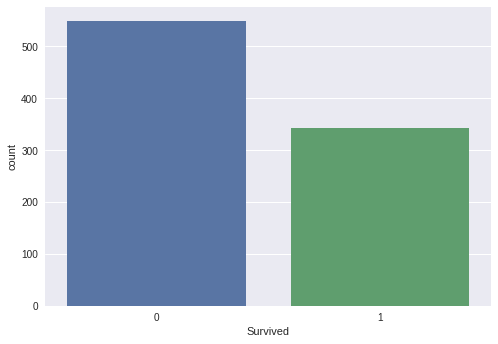

In [6]:
sns.countplot(train.Survived)
plt.show()

In [7]:
total = pd.concat([total,pd.get_dummies(total['Title'],prefix='Title')],axis=1)
total = pd.concat([total,pd.get_dummies(total['Embarked'],prefix='Embarked')],axis=1)
total = pd.concat([total,pd.get_dummies(total['Cabin'], prefix='Cabin')], axis=1)
total = pd.concat([total,pd.get_dummies(total['Pclass'], prefix="Pclass")],axis=1)
total = pd.concat([total,pd.get_dummies(total['Age'], prefix="Age")],axis=1)
total['Sex'] = total['Sex'].map({'male':1,'female':0})
#total = pd.concat([total, pd.get_dummies(total['TicketAlpha'], prefix='TicketAlpha')], axis=1)
#total = pd.concat([total, pd.get_dummies(total['TicketNum'], prefix='TicketNum')], axis=1)

In [8]:
total.drop('Title',axis=1,inplace=True)
total.drop('Embarked',axis=1,inplace=True)
total.drop('Cabin', axis=1, inplace=True)
total.drop('Pclass',axis=1,inplace=True)
total.drop('Ticket', inplace=True, axis=1)
total.drop('PassengerId', inplace=True, axis=1)
total.drop('Survived', axis=1, inplace=True)
total.drop('Age',axis=1, inplace=True)



In [9]:
data_y=train['Survived']
data_x=total.iloc[range(len(data_y))]
test_x=total.iloc[len(data_y):]


In [10]:
fixed_params = {
    'max_depth':3,
    'min_chil_weight':1,
    'learning_rate':0.1,
    'n_estimators':17,
    'gamma':0,
    'reg_alpha':1e-9,
    'random_state':seed,
    'subsample':0.8,
    'colsample_bytree':0.9,
    'objective':'binary:logistic',
}
model = xgb.XGBClassifier(**fixed_params)

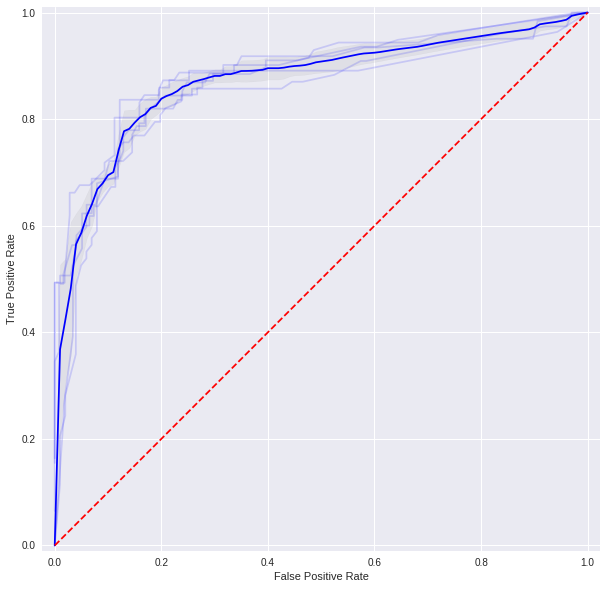

Model Report
Mean Accuray: 0.821568
Mean AUC: 0.872547
Mean Logloss 0.428030
[96 13]
[18 49]
[[96 13]
 [18 49]]
Mean Precision: 0.731343
Mean Recall: 0.790323


In [11]:
cross_validate(model, data_x, data_y,seed=seed, rep=1, cv=5)

In [ ]:
# 0.832007 0.880783
# 0.826388 0.869255
# 0.826956 0.871388
xgb.plot_importance(model)
plt.show()

In [42]:
# Find the best num_of_estimator until auc doesnt improve for 50 rounds
fixed_params = {
    'max_depth':3,
    'min_chil_weight':1,
    'learning_rate':0.1,
    'n_estimators':1000,
    'gamma':0,
    'reg_alpha':1e-9,
    'random_state':seed,
    'subsample':0.8,
    'colsample_bytree':0.9,
    'objective':'binary:logistic',
}
alg=xgb.XGBClassifier(**fixed_params)
xgb_param = alg.get_xgb_params()
xgtrain = xgb.DMatrix(data_x, label=data_y)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],
                  nfold=5,
                  metrics='auc',
                  early_stopping_rounds=50,
                  )
print cvresult.shape[0]

17


In [32]:
# disable gamma, reg_alpha
# train depth+child_weight
# gamma
# subsample+ subcol
# reg_alpha
cv_params = {
#    'max_depth':range(3,10),
#    'min_child_weight':range(6),
#    'gamma':[i/10.0 for i in range(0,10)],
#    'subsample':[0.5,0.6,0.7,0.8,0.9],
#    'colsample_bytree':[0.5,0.6,0.7,0.8,0.9],
#    'reg_alpha':[1e-9, 1e-7,1e-5,1e-3]
#    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
#    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05], 
#    'reg_alpha':[0.5,1,5,10],
#    'learning_rate':[0.05,0.1,0.2],
#    'n_estimators':[20,40,60,100,200]
}
fixed_params = {
    'max_depth':3,
    'min_chil_weight':1,
    'learning_rate':0.05,
    'n_estimators':33,
    'gamma':0,
#    'reg_alpha':1e-9,
    'random_state':seed,
    'subsample':0.8,
    'colsample_bytree':0.9,
    'objective':'binary:logistic',
}
optimized_gbm = GridSearchCV(xgb.XGBClassifier(**fixed_params),
                            cv_params,
                            scoring='roc_auc',
                            cv=5,
                            n_jobs=-1)
optimized_gbm.fit(data_x,data_y)


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_chil_weight=1, min_child_weight=1, missing=None,
       n_estimators=33, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=3423, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'reg_alpha': [1e-09, 1e-07, 1e-05, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [33]:
optimized_gbm.grid_scores_,optimized_gbm.best_params_,optimized_gbm.best_score_

([mean: 0.87707, std: 0.02972, params: {'reg_alpha': 1e-09},
  mean: 0.87707, std: 0.02972, params: {'reg_alpha': 1e-07},
  mean: 0.87707, std: 0.02972, params: {'reg_alpha': 1e-05},
  mean: 0.87707, std: 0.02972, params: {'reg_alpha': 0.001}],
 {'reg_alpha': 1e-09},
 0.8770702516777202)

In [46]:
fixed_params = {
    'max_depth':3,
    'min_chil_weight':1,
    'learning_rate':0.1,
    'n_estimators':17,
    'gamma':0,
    'reg_alpha':1e-9,
    'random_state':seed,
    'subsample':0.8,
    'colsample_bytree':0.9,
    'objective':'binary:logistic',
}
model = xgb.XGBClassifier(**fixed_params)
model.fit(data_x,data_y)
test_predictions = model.predict(test_x)
submission = pd.DataFrame({ 'PassengerId': test['PassengerId'],
                            'Survived': test_predictions })
submission.to_csv("submission_no_fare.csv", index=False)